**資科工碩 0756110 李東霖**

# Introduction

In [1]:
import dataloader
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from IPython.display import clear_output

In [3]:
def show_data(data):
    if len(data.shape) == 3:
        data = data[0]
        
    if len(data.shape) != 2:
        raise AttributeError("shape no ok")
        return
    
    plt.figure(figsize=(10,4))
    for i in range(data.shape[0]):
        plt.subplot(2,1, i+1)
        plt.ylabel("Channel "+str(i+1), fontsize=15)
        plt.plot(np.array(data[i, :]))
    plt.show()
    
def gen_dataset(train_x, train_y, test_x, test_y):
    datasets = []
    for x, y in [(train_x, train_y), (test_x, test_y)]:
        x = torch.stack(
            [torch.Tensor(x[i]) for i in range(x.shape[0])]
        )
        y = torch.stack(
            [torch.Tensor(y[i:i+1]) for i in range(y.shape[0])]
        )
        datasets += [TensorDataset(x, y)]
        
    return datasets

In [4]:
train_dataset, test_dataset = gen_dataset(*dataloader.read_bci_data())

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


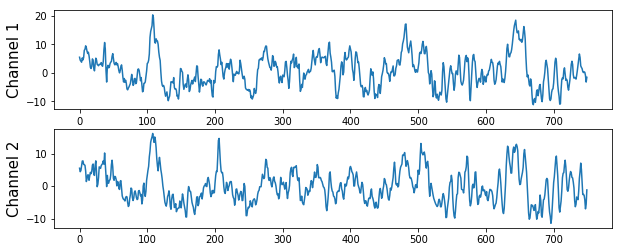

In [5]:
show_data(train_dataset[0][0])

# EEGNet

In [6]:
class EEGNet(nn.Module):
    def __init__(self, activation=None):
        if not activation:
            activation = nn.ELU
        
        super(EEGNet, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=(1, 51),
                stride=(1,1), padding=(0,25), bias=False
            ),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(
                16, 32, kernel_size=(2,1),
                stride=(1,1), groups=16, bias=False
            ),
            nn.BatchNorm2d(32),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(
                32, 32, kernel_size=(1, 15), 
                stride=(1,1), padding=(0, 7), bias=False
            ),
            nn.BatchNorm2d(32),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Linear(736, 2, bias=True)
        )
        
    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        # flatten
        x = x.view(-1, self.classify[0].in_features)
        x = self.classify(x)
        return x

In [73]:
def showAccuracy(title='', **kwargs):
    plt.figure(figsize=(8,4.5))
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    
    for label, data in kwargs.items():
        plt.plot(
            range(len(data)), data, 
            '--' if 'test' in label else '-', 
            label=label
        )
    
    plt.legend(
        loc='best', bbox_to_anchor=(1.0, 1.0, 0.2, 0),
        fancybox=True, shadow=True
    )
    plt.show()

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eegs = {
    "elu" : EEGNet(nn.ELU).to(device),
    "relu" : EEGNet(nn.ReLU).to(device),
    "leaky_relu" : EEGNet(nn.LeakyReLU).to(device),
}
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam
optimizers = {
    key: optimizer(value.parameters()) 
    for key, value in eegs.items()
}
print(device)

cuda


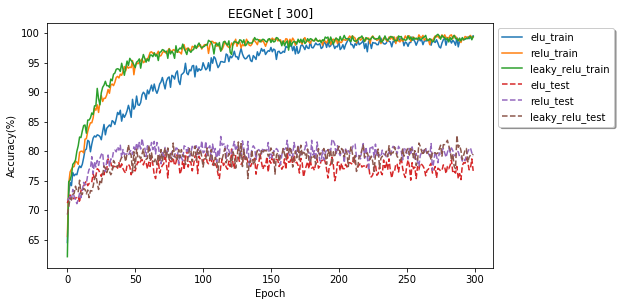

CPU times: user 4min 23s, sys: 13.5 s, total: 4min 37s
Wall time: 4min 37s


In [77]:
%%time
# Training & Testing
epoch_size = 300
batch_size = 27

train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, len(test_dataset))

Accs = {
    **{key+"_train" : [] for key in eegs},
    **{key+"_test" : [] for key in eegs}
}
for epoch in range(epoch_size):
    train_correct = {key:0.0 for key in eegs}
    test_correct = {key:0.0 for key in eegs}
    for idx, data in enumerate(train_loader):
        x, y = data
        inputs = x.to(device)
        labels = y.to(device).long().view(-1)
        
        for optimizer in optimizers.values():
            optimizer.zero_grad()
        
        for key, eeg in eegs.items():
            outputs = eeg(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            train_correct[key] += (
                torch.max(outputs, 1)[1] == labels
            ).sum().item()
        
        for optimizer in optimizers.values():
            optimizer.step()
        
    for _, data in enumerate(test_loader):
        x, y = data
        inputs = x.to(device)
        labels = y.to(device)
        
        for key, eeg in eegs.items():
            outputs = eeg(inputs)
        
            test_correct[key] += (
                torch.max(outputs, 1)[1] == labels.long().view(-1)
            ).sum().item()

    for key, value in train_correct.items():
        Accs[key+"_train"] += [(value*100.0) / len(train_dataset)]
    
    for key, value in test_correct.items():
        Accs[key+"_test"] += [(value*100.0) / len(test_dataset)]
    
                                    
    clear_output(wait=True)
    showAccuracy(
        title='EEGNet [{:4d}]'.format(epoch + 1),
        **Accs
    )

torch.cuda.empty_cache()